In [2]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import opening, closing, disk

In [3]:
%matplotlib widget

### Load Sharpened Images with their Masks

In [33]:
# images
left_ims = glob.glob('trees/sharpened/sharpened_left_*.png')
right_ims = glob.glob('trees/sharpened/sharpened_right_*.png')

# masks
left_masks = glob.glob('trees/matlab_masks/mask_left_*.png')
right_masks = glob.glob('trees/matlab_masks/mask_right_*.png')

assert(len(left_ims) == len(right_ims))
assert(len(left_masks) == len(right_masks))

### Create Disparity Maps and Mask Them

In [ ]:
from depthMap import maskDisparityMaps

maskDisparityMaps(left_ims, right_ims, left_masks)

### Save Disparity Values for Regression Line

In [ ]:
from depthMap import extractDisparityValues

 # ------------------------------------- #
# LOAD IMAGES
# ------------------------------------- #
left_ims = glob.glob('area4/left_*.png')
right_ims = glob.glob('area4/right_*.png')


extractDisparityValues(left_ims, right_ims)

### Regression Line (Short: <15m)

In [ ]:
dist = np.linspace(2.0, 11.6, 33)
disp = np.array([186, 207, 178, 129, 124, 113, 104, 168, 94, 88, 160, 97, 78, 73, 74, 
                 77, 66, 66, 62, 60, 108, 56, 94, 53, 51, 50, 49, 46, 45, 80, 44, 93, 41])

len(disp) == len(dist)

### Regression Line 2 (Short: <15m)

##### Rational Function

In [4]:
def disp2dist(x):
    '''
    Computes the distance given a disparity value between 0 & 255\n
    x must be a number or a numpy array
    The rational function was fitted using MATLAB's curveFitter App
    '''
    return (507.7*pow(x,2) -214.7*x + 10.1) / (pow(x,3) + 76.2*pow(x,2) -3057*x - 139.7)

In [5]:
def fit_disp2dist(x):
    '''
    disp = [113, 113, 94, 89, 82, 77, 70, 70, 70, 65, 60, 55, 53, 51, 50, 49, 48, 46, 44, 
        42, 41, 40, 39, 38, 37, 36, 37, 36, 36, 34, 34, 33, 33]
    
    dist = np.linspace(3.0, 12.6, 33)
    '''
    y = (378*x**2 -1485*x - 76.37) / (x**3 + 6.802*x**2 - 400.3*x - 1003)
    return y

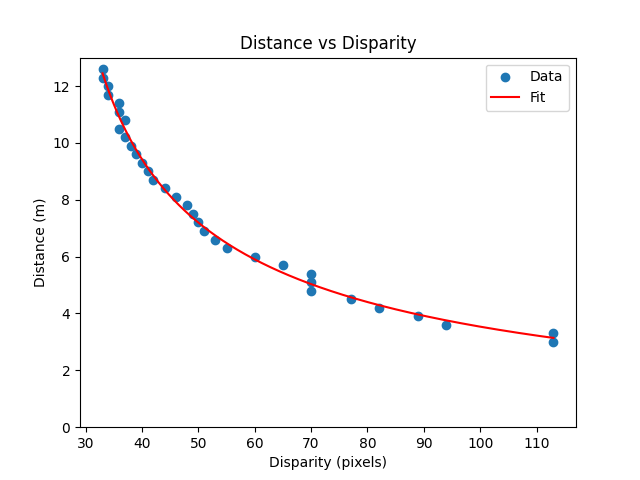

In [70]:
disp = [113, 113, 94, 89, 82, 77, 70, 70, 70, 65, 60, 55, 53, 51, 50, 49, 48, 46, 44, 
        42, 41, 40, 39, 38, 37, 36, 37, 36, 36, 34, 34, 33, 33]
dist = np.linspace(3.0, 12.6, 33)
x = np.linspace(33, 113, 800)
y = fit_disp2dist(x)

plt.close()
plt.figure()
plt.scatter(disp, dist, label='Data')
plt.plot(x, y, 'r', label='Fit')
plt.xlabel('Disparity (pixels)')
plt.ylabel('Distance (m)')
plt.ylim(bottom=0, top=13)
plt.title('Distance vs Disparity')
plt.legend()
plt.show()

##### Polynomial (Cubic)

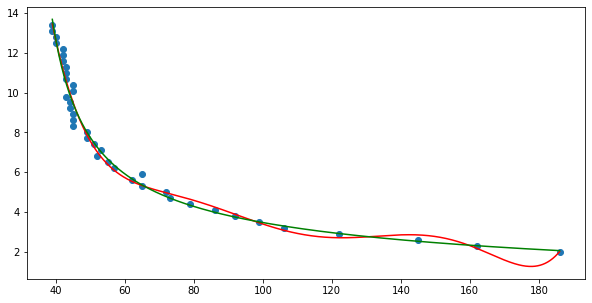

In [94]:
dist1 = np.linspace(2.0, 13.4, 39)
disp1 = np.array([186, 162, 145, 122, 106, 99, 92, 86, 79, 73, 72, 65, 62, 65, 57, 55, 52, 
    53, 51, 49, 49, 45, 45, 45, 44, 44, 43, 45, 45, 43, 43, 43, 42, 42, 42, 40, 40, 39, 39])

model = np.poly1d(np.polyfit(disp1, dist1, 6))
points = np.linspace(39, 186, 600)

plt.figure(figsize=(10, 5))
plt.plot(points, model(points), color='r')
plt.scatter(disp1, dist1)
plt.plot(points, disp2dist(points), color='g')
plt.show()

### Regression Line 3 (Long: Up to 35m)

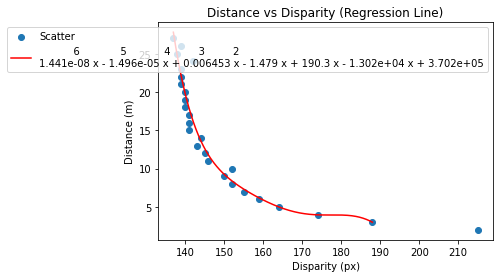

In [29]:
dist = np.arange(2, 28, 1)
disp = np.array([215, 188, 174, 164, 159, 155, 152, 150, 152, 146, 
                145, 143, 144, 141, 141, 141, 140, 140, 140, 139, 139, 139, 142, 138, 139, 137])

# x = np.arange(137, 216, 1)
# y = np.exp(23.08) * (1.2442 ** -x) * (1.006 ** (x ** 2))

# polynomial fit
model = np.poly1d(np.polyfit(disp, dist, 6))
polyline = np.linspace(137, 188, 400)

# exponential fit
# fit = np.polyfit(disp, np.log(dist), 2)
# print(fit)

plt.figure()
plt.scatter(disp, dist, label='Scatter')
# plt.plot(x, y)
plt.plot(polyline, model(polyline), color='red', label=str(model))
plt.xlabel('Disparity (px)')
plt.ylabel('Distance (m)')
plt.title('Distance vs Disparity (Regression Line)')
plt.legend()
plt.show()


### Top, base, Left and Right Extreme Pixels

In [127]:
%matplotlib widget
img = cv2.imread('depthMap.png', 0)

def convex_hull(img):
    '''
    Finds the tip pixels on the left, right, base and top of the image
    '''
    rows, cols = img.nonzero()
    base = (rows.max(), cols[np.where(rows == rows.max())][0])
    top =  (rows.min(), cols[np.where(rows == rows.min())][0])
    left =  (rows[np.where(cols == cols.min())][0], cols.min())
    right = (rows[np.where(cols == cols.max())][0], cols.max())
   
    return base, top, left, right

[base, top, left, right] = convex_hull(img)

In [128]:
base

(683, 683)

In [9]:
disp2dist(99)

3.503173713766546

In [123]:
def compute_bh(img, zc, baseline=0.129, f=1438):
    '''
    Traces a horizontal line passing through the breast height of the tree
    @ img: Source image
    @ zc: Real world depth of trunk base
    '''
    disparity = baseline * f / zc
    base = convex_hull(img)[0]
    xc = baseline * (base[0] - 360) / disparity
    yc = baseline * (base[1] - 640) / disparity
    print(f"Real world coordinates of trunk base: {xc, yc, zc}")

    # applying the geometry for deriving the position of the breast height
    dg = np.sqrt(xc**2 + yc**2 + zc**2)
    phi = np.arctan(yc / zc)
    beta = (np.pi/2 - phi)
    dh = np.sqrt(1.69 + dg**2 - 2.6*dg*np.cos(beta))
    theta = np.arcsin(1.3 * np.sin(beta) / dh)
    sh = 2822.61 * np.tan(theta/2) # no. of pixels from base to the breast height (1.3m above the ground)
    bh = base[0] - np.int64(sh) # row number where breast height is found
    
    return bh

In [173]:
def plot_bh(img, bh):
    
    plt.figure(figsize=(8,3))
    plt.imshow(img, 'gray')
    plt.hlines(bh, 0, 1279, colors='r')
    plt.show()

In [189]:
def compute_dbh(sd, da, measured):
    theta = np.arctan(sd * 3.546e-4)
    R = da * np.arctan(theta)
    print(f"DBH: {2*R}")
    print(f"%Error: {np.abs(2*R - measured)/measured * 100}")

In [118]:
def pixel_of_interest(image, parameter:str, value:int):
    pixels = []
    [base, top, left, right] = convex_hull(image)

    if parameter == 'dbh':
        bh = compute_bh(image, zc=5)
        
        rows, columns = np.nonzero(image[value-2:value+3, :])
        for row, column in zip(rows, columns):
            pixels.append(image[value+row, column])
            
    elif parameter == 'th':
        rows, columns = np.nonzero(image[value-2:value+3, :])
        for row, column in zip(rows, columns):
            pixels.append(image[value+row, column])

    pixels = np.array(pixels)
    print(pixels)
    return np.median(pixels)

In [195]:
def median_base_pixel(image):
    pixels = []
    base = convex_hull(image)[0]

    sub_image = image[base[0] - 20 : base[0] + 1, :]
    rows, columns = np.nonzero(sub_image)
    for row, column in zip(rows, columns):
        pixels.append(sub_image[row, column])
    
    # print(pixels)
    pixels = np.array(pixels)
    half_pixels = np.split(np.sort(pixels), 2)

    return [np.median(pixels), np.median(half_pixels)]

In [15]:
compute_dbh(76, 0.2769)

DBH: 0.2747529299643451
%Error: 0.7753954624972542


In [225]:
def computeDepthMap(imgL, imgR, mask):
    
    # ------------------------------------- #
    # SETUP
    # ------------------------------------- #
    imgL = cv2.GaussianBlur(imgL, (5,5), 0)
    imgR = cv2.GaussianBlur(imgR, (5,5), 0)

    # read camera data
    data = cv2.FileStorage('stereo_params_v7.yml', cv2.FILE_STORAGE_READ)
    keys = ["K1", "K2", "D1", "D2", "R1", "R2", "P1", "P2", "T"]
    [K1, K2, D1, D2, R1, R2, P1, P2, T] = [data.getNode(key).mat() for key in keys]

    '''
    We know that

            |f  0   cx1  0|
    P1 =    |0  f   cy   0|
            |0  f   1    0|

    and 

            |f  0   cx2  Tx*f|
    P2 =    |0  f   cy   0   |
            |0  f   1    0   |

    and in our case, cx1 = cx2 = cx
    '''

    f = K1[0,0]
    Tx = T[0,0]
    P1 = np.hstack((K1, np.array([[0],[0],[0]])))
    P2 = np.hstack((K2, np.array([[Tx*f],[0],[0]])))


    # ------------------------------------- #
    # STEREO RECTIFICATION
    # ------------------------------------- #
    h1, w1 = imgL.shape

    # rectify images using initUndistortRectifyMap
    xmap1, ymap1 = cv2.initUndistortRectifyMap(K1, D1, R1, P1, (w1,h1), cv2.CV_32FC1)
    xmap2, ymap2 = cv2.initUndistortRectifyMap(K2, D2, R2, P2, (w1,h1), cv2.CV_32FC1)

    imgL_rectified = cv2.remap(imgL, xmap1, ymap1, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
    imgR_rectified = cv2.remap(imgR, xmap2, ymap2, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
#     mask_rectified = cv2.remap(mask, xmap1, ymap1, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)

    # -------------------------------- #
    # COMPUTE DISPARITY MAP
    # -------------------------------- #

    # Matched blocked size
    block_size = 11
    min_disp = -128
    max_disp = 128
    num_disp = max_disp - min_disp
    uniquenessRatio = 5
    speckleWindowSize = 200
    speckleRange = 2
    disp12MaxDiff = 0

    stereo = cv2.StereoSGBM_create(
                    minDisparity=min_disp,
                    numDisparities=num_disp,
                    blockSize=block_size,
                    uniquenessRatio=uniquenessRatio,
                    speckleWindowSize=speckleWindowSize,
                    speckleRange=speckleRange,
                    disp12MaxDiff=disp12MaxDiff,
                    P1=8 * block_size * block_size,
                    P2=32 * block_size * block_size
                    )

    disparity_SGBM = stereo.compute(imgL_rectified, imgR_rectified)
    disparity_SGBM = cv2.normalize(disparity_SGBM,
                            disparity_SGBM,
                            beta=0,
                            alpha=255,
                            norm_type=cv2.NORM_MINMAX)
    disparity_SGBM = np.uint8(disparity_SGBM)
    # cv2.imwrite('disparitySGBM.png', disparity_SGBM)


    # -------------------------------- #
    # FILTER DISPARITY MAP
    # -------------------------------- #
    right_matcher = cv2.ximgproc.createRightMatcher(stereo)
    # filter parameters
    lmbda = 80000
    sigma = 1.8
    visual_multiplier = 6

    wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=stereo)
    wls_filter.setLambda(lmbda)
    wls_filter.setSigmaColor(sigma)

    dispL = stereo.compute(imgL_rectified, imgR_rectified)
    dispR = right_matcher.compute(imgR_rectified, imgL_rectified)

    dispL = np.int16(dispL)
    dispR = np.int16(dispR)

    filteredImg = wls_filter.filter(dispL, imgL_rectified, None, dispR)
    # Normalize the values to the range 0-255 for a grayscale image
    filteredImg = cv2.normalize(filteredImg,
                            filteredImg,
                            beta=0,
                            alpha=255,
                            norm_type=cv2.NORM_MINMAX)
    filteredImg = np.uint8(filteredImg)
#     filteredImg[mask == 0] = 0
    return filteredImg

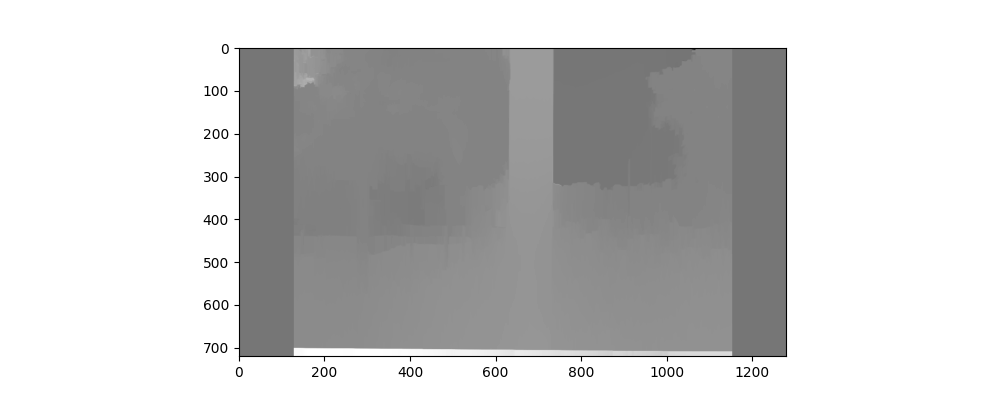

In [226]:

# ------------------------------------- #
# LOAD IMAGES
# ------------------------------------- #
# imgL = cv2.imread('trees2/images/left_10.png', 0)
# imgR = cv2.imread('trees2/images/right_10.png', 0)
# mask = cv2.imread('trees2/mask_10.png', 0)

imgL = cv2.imread('trees/left_5.png', 0)
imgR = cv2.imread('trees/right_5.png', 0)
mask = cv2.imread('trees/masked_disparity_maps/masked_disparity_8.png', 0)

depth = computeDepthMap(imgL, imgR, mask)

plt.close()
plt.figure(figsize=(10,4))
plt.imshow(depth, 'gray')
plt.show()

Real world coordinates of trunk base: (0.9150720148737711, 0.3335585086475359, 4.24475341093059)
250


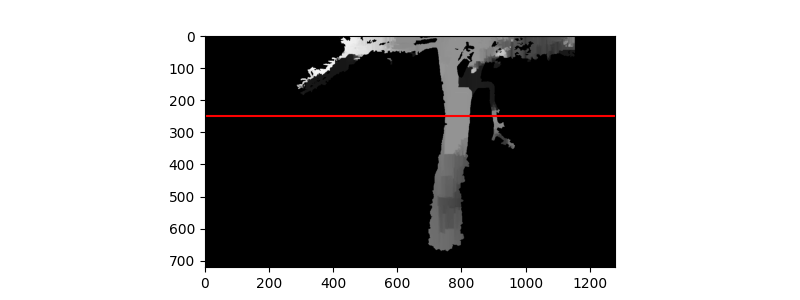

In [213]:
[base, top, left, right] = convex_hull(depth)
zc = fit_disp2dist(median_base_pixel(depth)[0])

bh = compute_bh(depth, zc)
print(bh)
plot_bh(depth, bh)

In [205]:
px = np.nonzero(depth[bh, :])[0]
sz = px.size
print(sz)
da = fit_disp2dist(median_base_pixel(depth)[1])
compute_dbh(sz, da, 0.452)

109
DBH: 0.4403696584389267
%Error: 2.5730844161666564
